In [17]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = io*np.pi/180 #np.radians(io) #inclination #25.86
    pa = pa*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist.dr16beta.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits' , 1)
clnpdfout = pdfout[clnr]

Labels for PARSEC isochrones

0 = PMS, pre main sequence

1 = MS, main sequence

2 = SGB, subgiant branch, or Hertzsprung gap for more intermediate+massive stars

3 = RGB, red giant branch, or the quick stage of red giant for intermediate+massive stars

4 = CHEB, core He-burning for low mass stars, or the very initial stage of CHeB for intermediate+massive stars

5 = still CHEB, the blueward part of the Cepheid loop of intermediate+massive stars

6 = still CHEB, the redward part of the Cepheid loop of intermediate+massive stars

7 = EAGB, the early asymptotic giant branch, or a quick stage of red giant for massive stars

8 = TPAGB, the thermally pulsing asymptotic giant branch

9 = post-AGB (in preparation!)

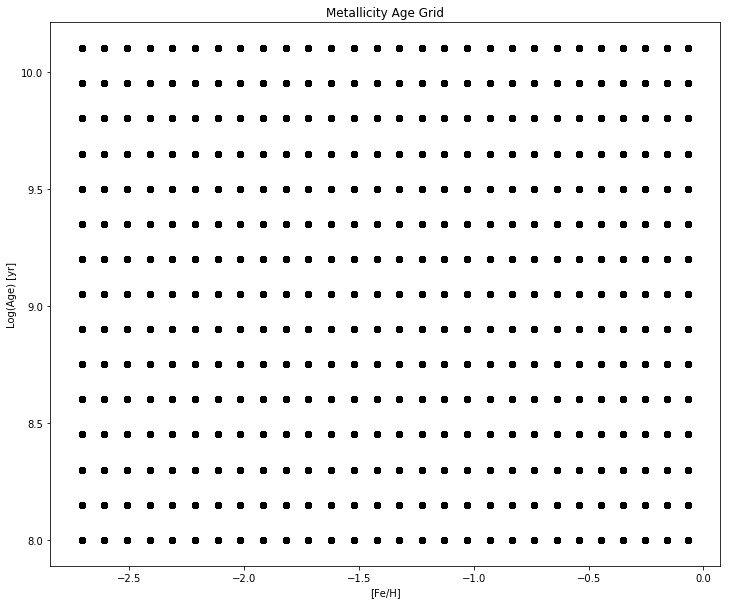

In [3]:
#Metallicity Age
plt.figure(figsize=[12,10])
plt.scatter(np.log10(parsec['Zini']/0.02),parsec['logAge'],c='k',cmap='jet')
plt.ylabel(r'Log(Age) [yr]')
plt.xlabel(r'[Fe/H]')
plt.title(r'Metallicity Age Grid')
plt.savefig('PARSECgrid.pdf',bbox_inches='tight')
plt.show()

In [4]:
import itertools as it

y1 = parsec['logTe']
y2 = parsec['Ksmag']
y3 = np.log10(parsec['Zini']/0.02)
y4  = parsec['logg']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

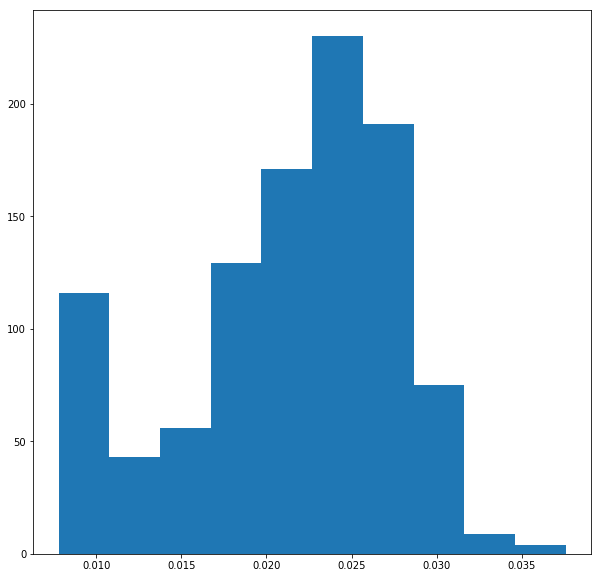

0.007780979977408009
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y23', 'y24', 'y34', 'y2sq',
       'y3sq', 'y4sq'], dtype='<U4')]
[array([ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,
       -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,
       -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,
        6.19034227e-01])]


In [5]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

In [6]:
small = np.where(np.asarray(model_mads)<=0.01)

terms = []
for i in range(len(models_str_good[small])):
    terms.append(len(models_str_good[small][i]))
    
print(terms)
# print(models_str_good[small][0])

parsimonious = np.array([y1,y2,y3,y4,y12,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y34,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y1sq,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y14,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y23,y24,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

parsimonious = np.array([y1,y2,y3,y4,y24,y34,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))
print('mad',mad(parsimonious_residual))

parsimonious = np.array([y1,y2,y3,y4,y24,y1sq,y2sq,y3sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.825e+06
Date:                Fri, 23 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:48:58   Log-Likelihood:                 46192.
No. Observations:               16121   AIC:                        -9.236e+04
Df Residuals:                   16111   BIC:                        -

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.168e+06
Date:                Fri, 23 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:48:58   Log-Likelihood:                 44058.
No. Observations:               16121   AIC:                        -8.810e+04
Df Residuals:                   16111   BIC:                        -8.802e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.9917      0.183     92.633      0.0

In [3]:
##########################
### Define Model Above ###
##########################

# def parfit(x1,x2,x3,x4):
#     p = [ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,\
#        -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,\
#        -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,\
#         6.19034227e-01]
#     return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
# p[7]*np.multiply(x2,x3)+p[8]*np.multiply(x2,x4)+p[9]*np.multiply(x3,x4)+p[10]*(x2**2)+p[11]*(x3**2)+p[12]*\
#(x4**2)

def parfit(x1,x2,x3,x4):
    p = [19.57711154,  1.62799079,  4.41723963,  0.24957004, -7.04845086, -0.39628751,\
 -0.5399325,   0.11835753,  0.05859978,  0.63493432]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x2,x4)+\
p[7]*(x2**2)+p[8]*(x3**2)+p[9]*(x4**2)

In [4]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    factsCN.append(numerCN/denomCN)
factsCN = factsCN[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parfit(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])

In [5]:
sol_xm[1]

0.06901474154376043

In [6]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [7]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
#     am = clndr16['ALPHA_M'][i]
#     amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parfit(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

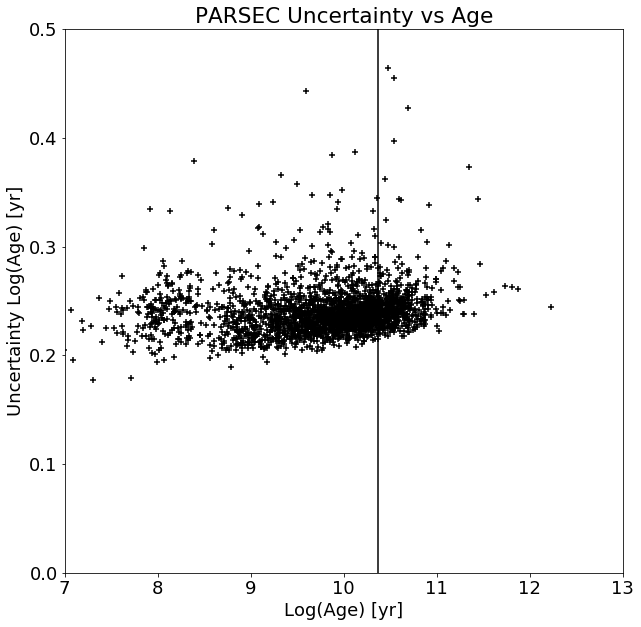

In [41]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(parage,devs,c='k',marker='+',label='Polynomial')
#plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Bayesian')
plt.xlim(7,13)
plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,0.5)
plt.title(r'PARSEC Uncertainty vs Age')
#plt.legend()
plt.savefig('parsec_uncert_age.pdf',bbox_inches='tight')
plt.show()

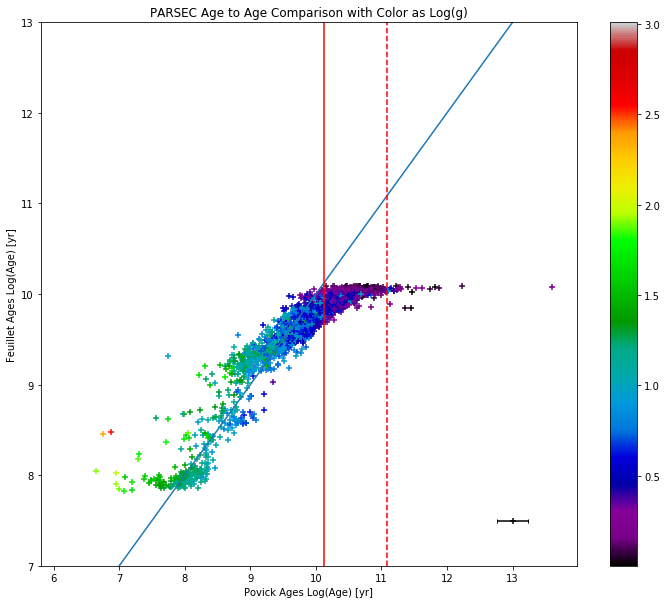

In [9]:
#lowgrav = np.where(clndr16['LOGG']<0.20)
plt.figure(figsize=[12,10])
#plt.scatter(parage[lowgrav],clnpdfout['P_MEAN'][lowgrav],c=clndr16['LOGG'][lowgrav],marker='+',\
            #cmap='nipy_spectral')
plt.scatter(parage,clnpdfout['P_MEAN'],c=clndr16['LOGG'],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:blue')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+max(devs),c='r',linestyle='--')
plt.xlabel(r'Povick Ages Log(Age) [yr]')
plt.ylabel(r'Feuillet Ages Log(Age) [yr]')
plt.title(r'PARSEC Age to Age Comparison with Color as Log(g)')
plt.savefig('parsec_age_age.pdf',bbox_inches='tight')
plt.show()

In [10]:
print(ageU)

13208053784.589062


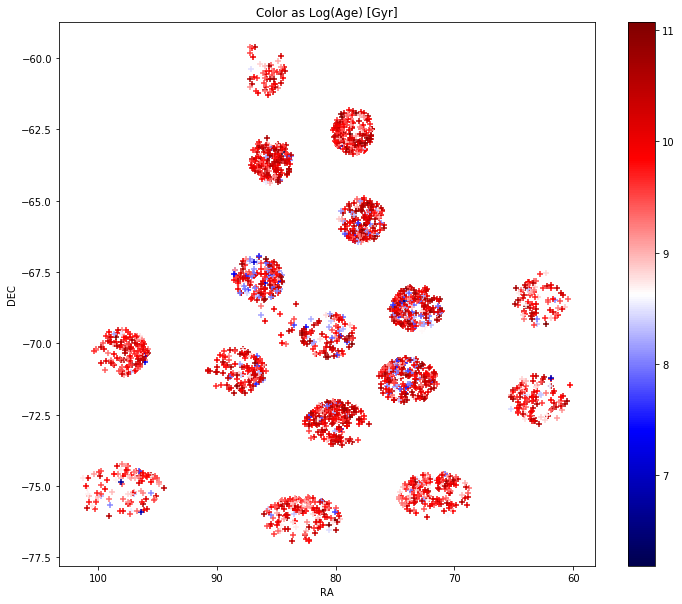

In [11]:
#######################
### Age vs Position ###
#######################

zero = np.where(clnpdfout['P_MEAN']>=0)
young = np.where(parage<=10.13+max(devs))

plt.figure(figsize=[12,10])
plt.scatter(clndr16['RA'][young],clndr16['DEC'][young],c=parage[young],marker='+',cmap='seismic')
# plt.scatter(clndr16['RA'][zero],clndr16['DEC'][zero],c=clnpdfout['P_MEAN'][zero],marker='+',cmap='seismic')
plt.colorbar()
plt.gca().invert_xaxis()
plt.title(r'Color as Log(Age) [Gyr]')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()


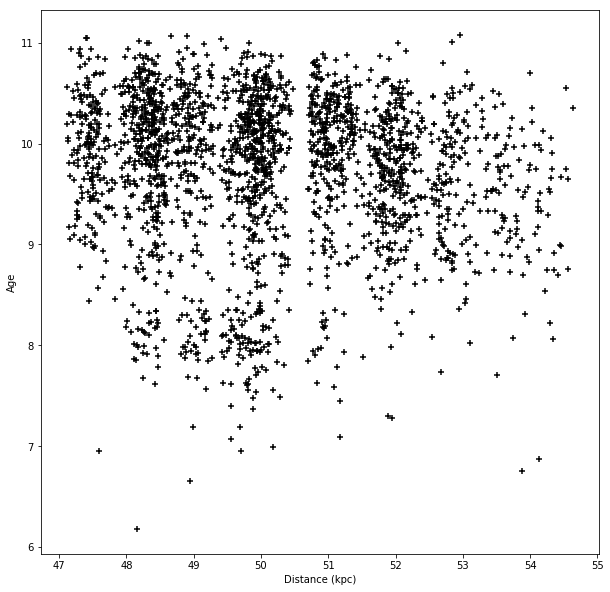

In [12]:
#######################
### Distance vs Age ###
#######################

plt.figure(figsize=[10,10])
#plt.scatter(stardist[zero],clnpdfout['P_MEAN'][zero],marker='+',c='k')
plt.scatter(stardist[young],parage[young],marker='+',c='k')
plt.xlabel(r'Distance (kpc)')
plt.ylabel(r'Age')
plt.show()


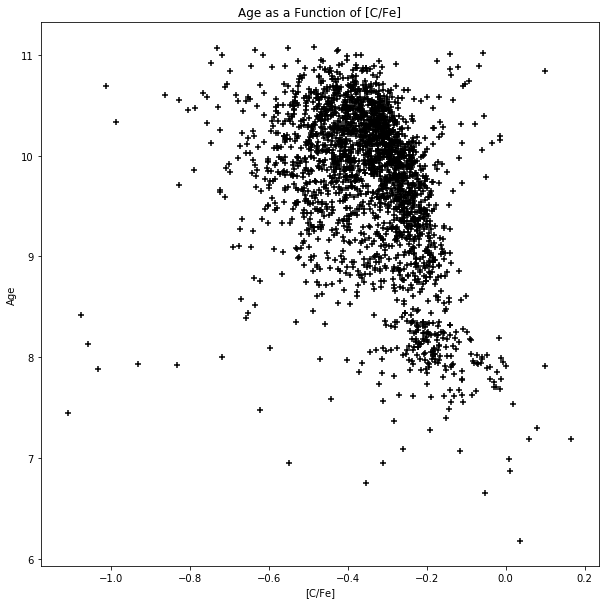

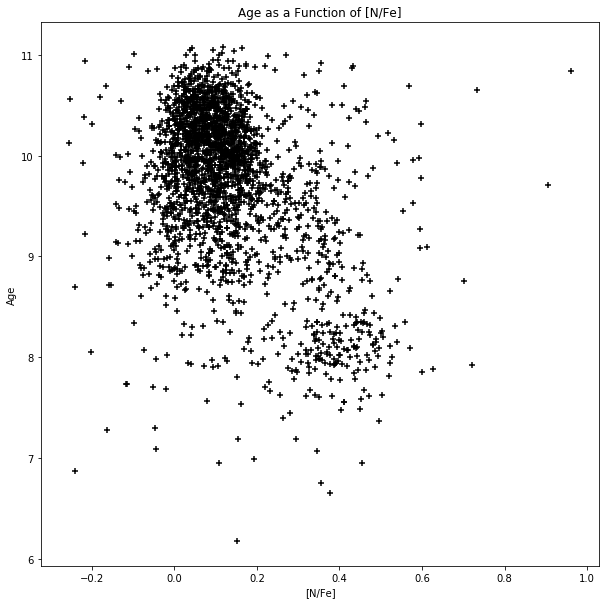

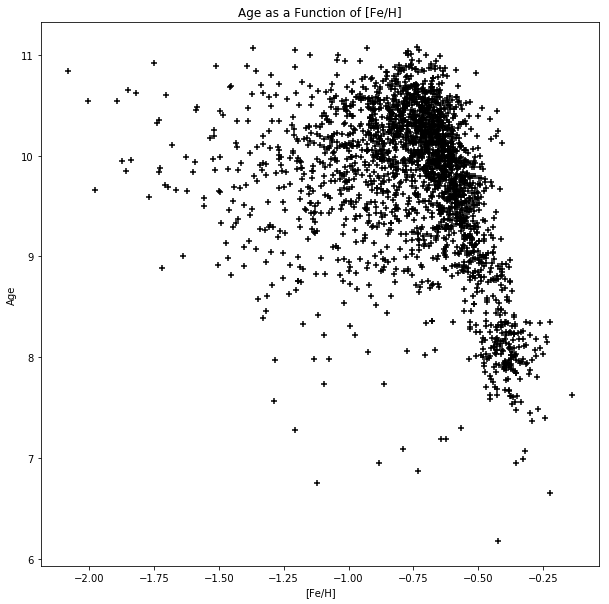

In [13]:
################
### Abudance ###
################

plt.figure(figsize=[10,10])
plt.scatter(clndr16['C_FE'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[C/Fe]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [C/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['N_FE'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[N/Fe]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [N/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['FE_H'][young],parage[young],marker='+',c='k')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of [Fe/H]')
plt.show()

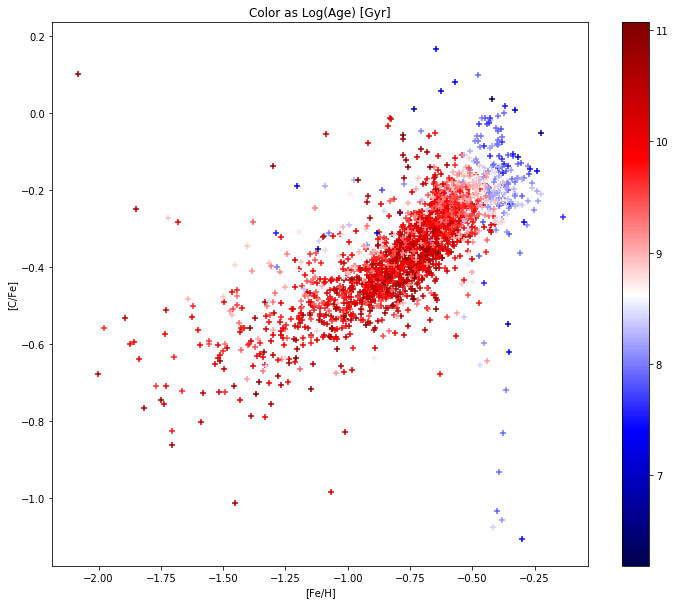

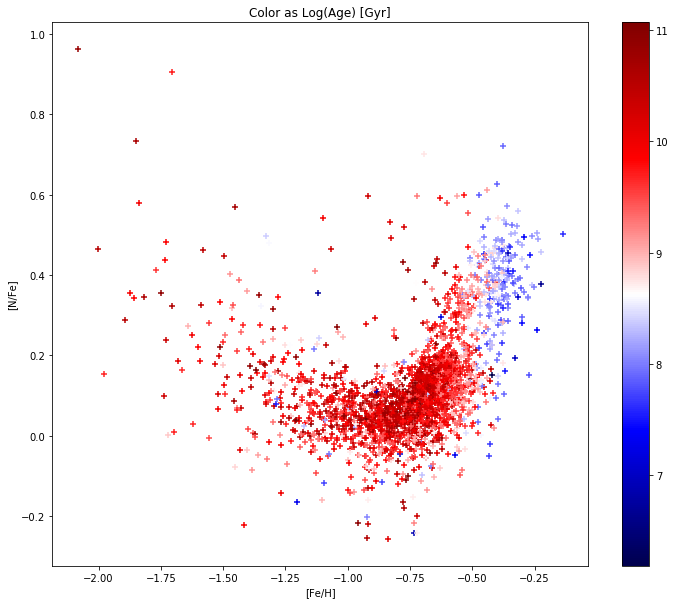

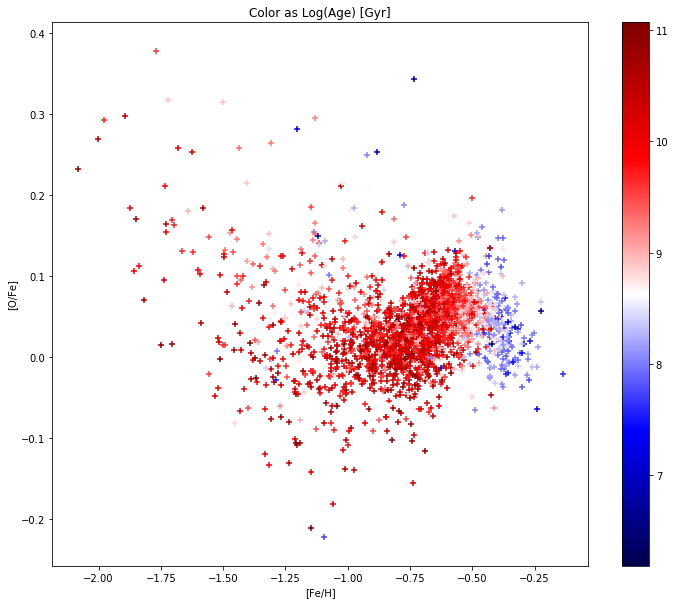

In [14]:
plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['C_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[C/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['N_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[N/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['FE_H'][young],clndr16['O_FE'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[O/Fe]')
plt.title(r'Color as Log(Age) [Gyr]')
plt.colorbar()
plt.show()

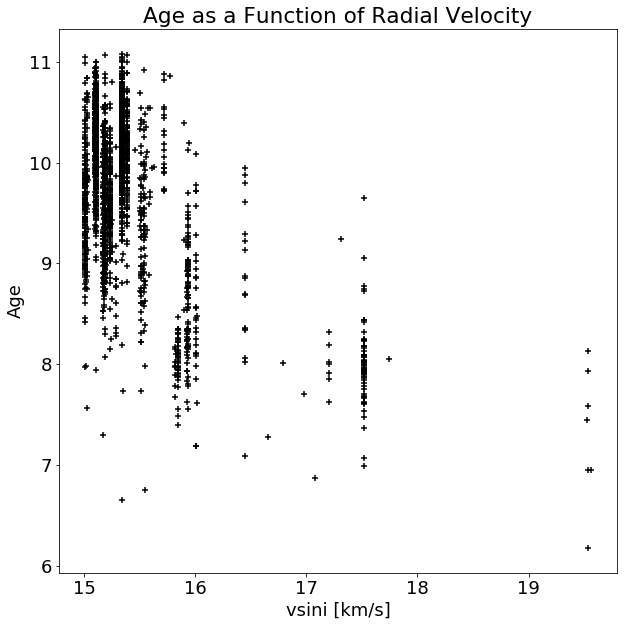

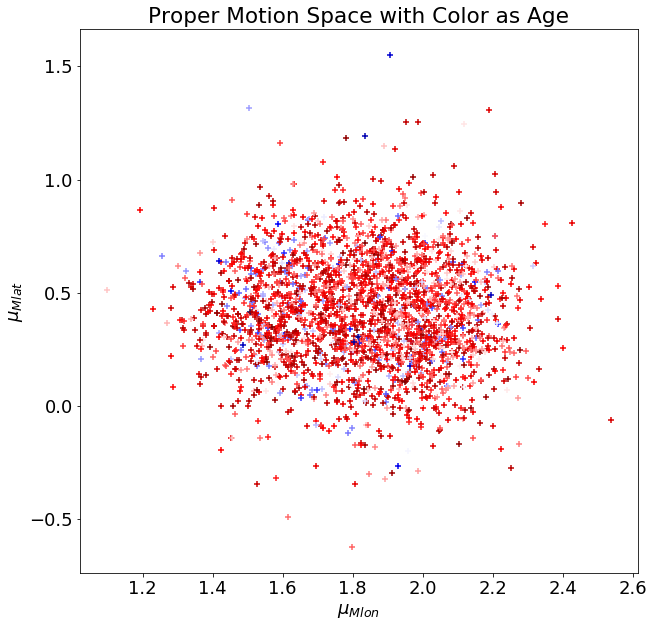

In [20]:
##################
### Kinematics ###
##################

plt.figure(figsize=[10,10])
plt.scatter(clndr16['RV_AUTOFWHM'][young],parage[young],marker='+',c='k')
plt.xlabel(r'vsini [km/s]')
plt.ylabel(r'Age')
plt.title(r'Age as a Function of Radial Velocity')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(clndr16['GAIA_PMML'][young],clndr16['GAIA_PMMB'][young],c=parage[young],marker='+',cmap='seismic')
plt.xlabel(r'$\mu_{Mlon}$')
plt.ylabel(r'$\mu_{Mlat}$')
plt.title(r'Proper Motion Space with Color as Age')
plt.show()

In [38]:
###############
### SNR Cut ###
###############

cut = np.where(clndr16[young]['SNR']>80)
dr16snr = clndr16[young][cut]

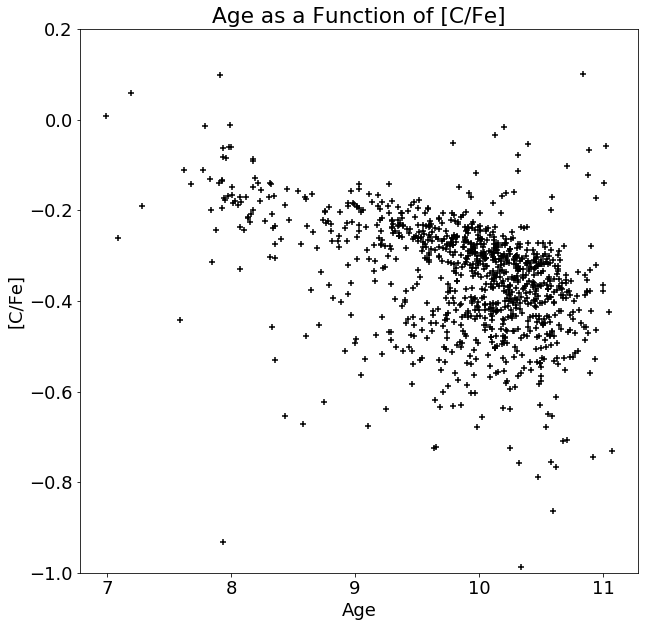

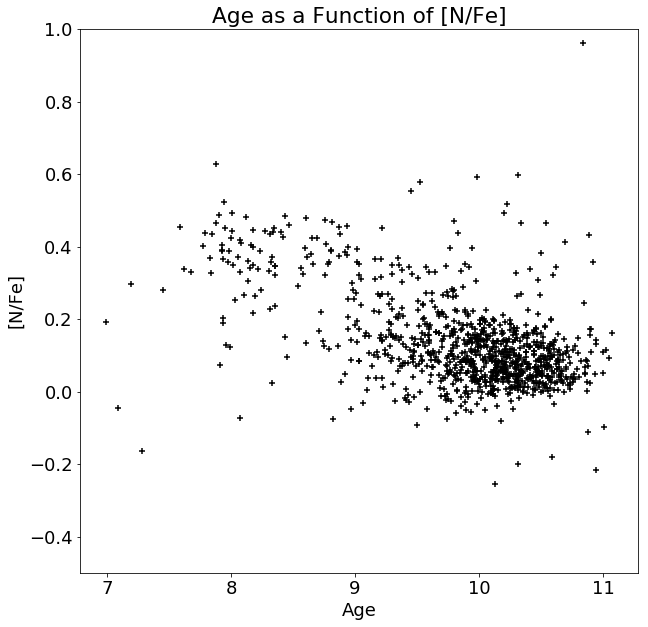

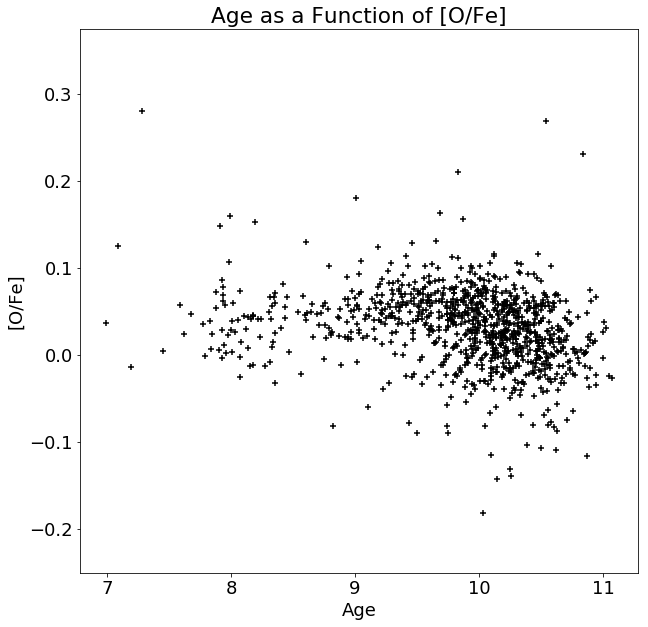

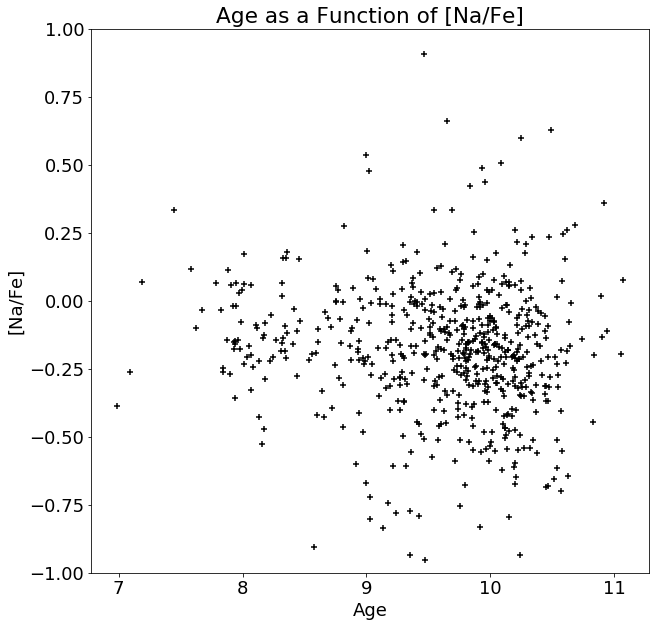

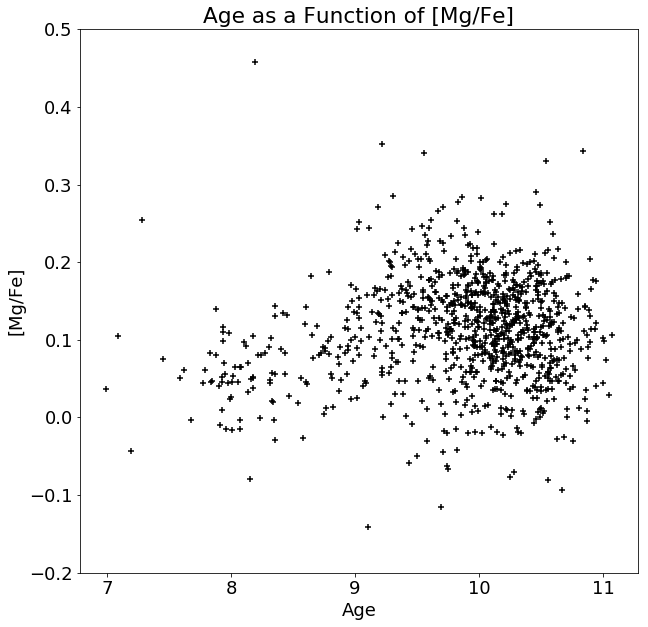

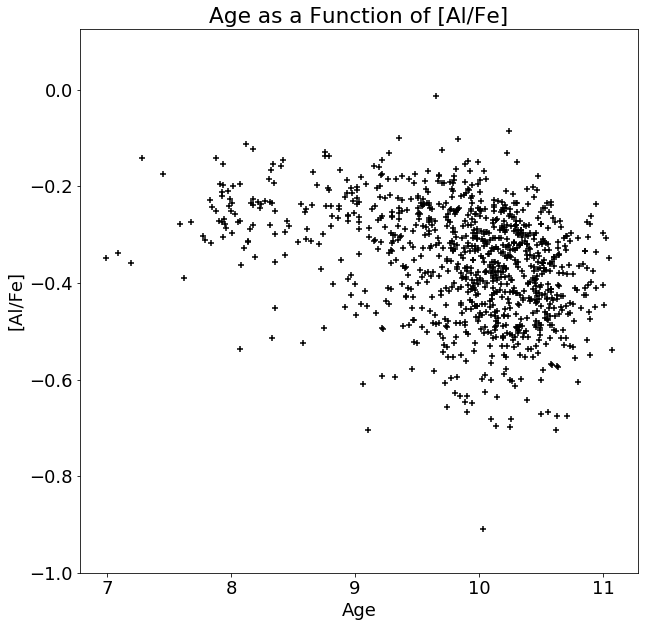

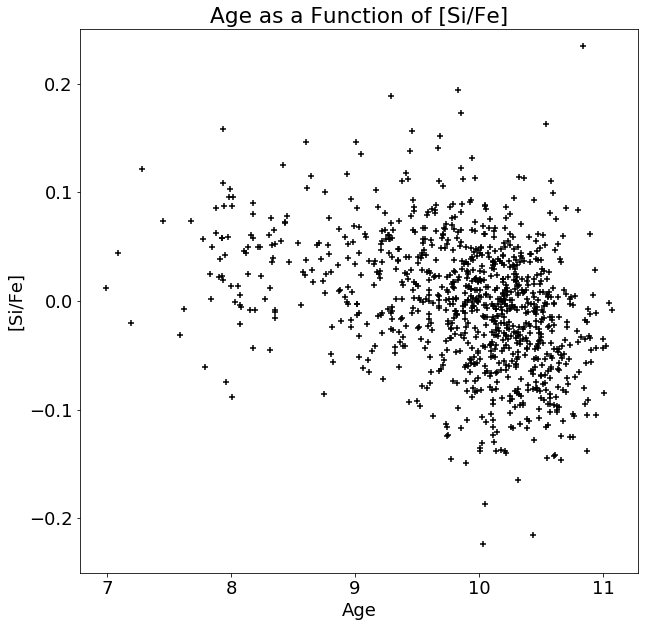

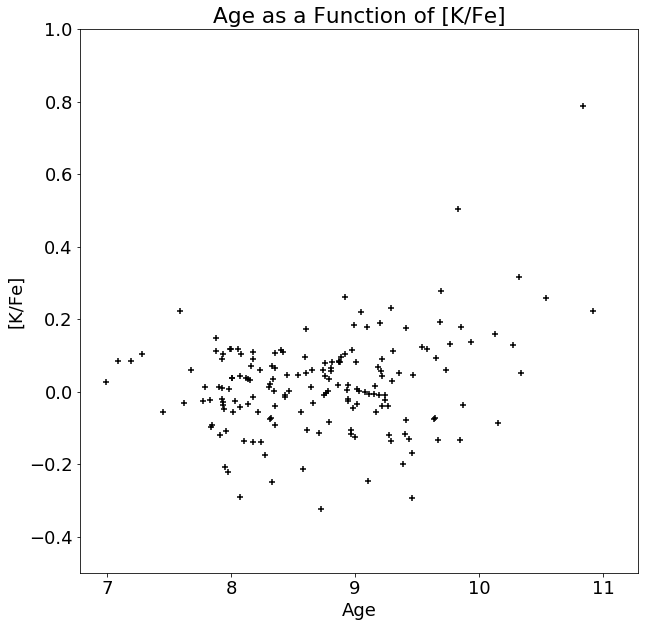

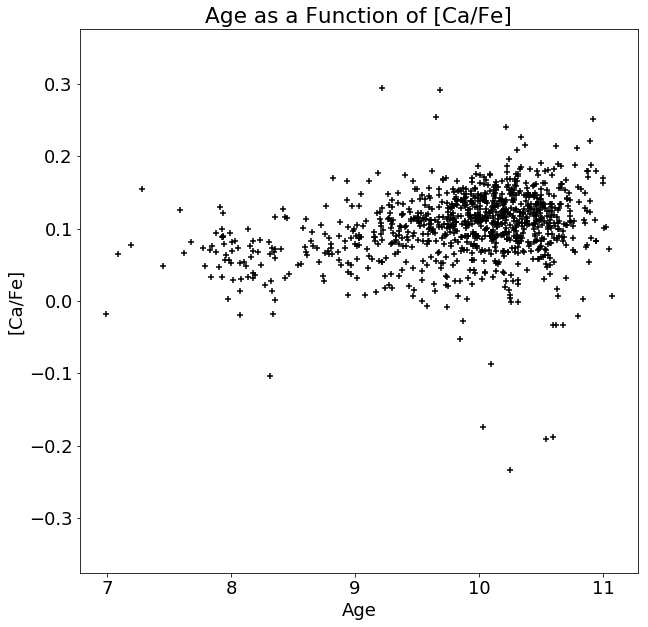

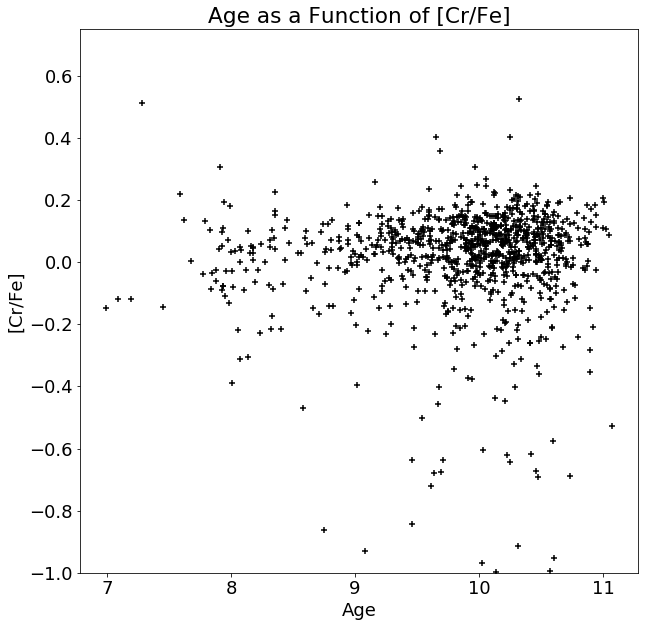

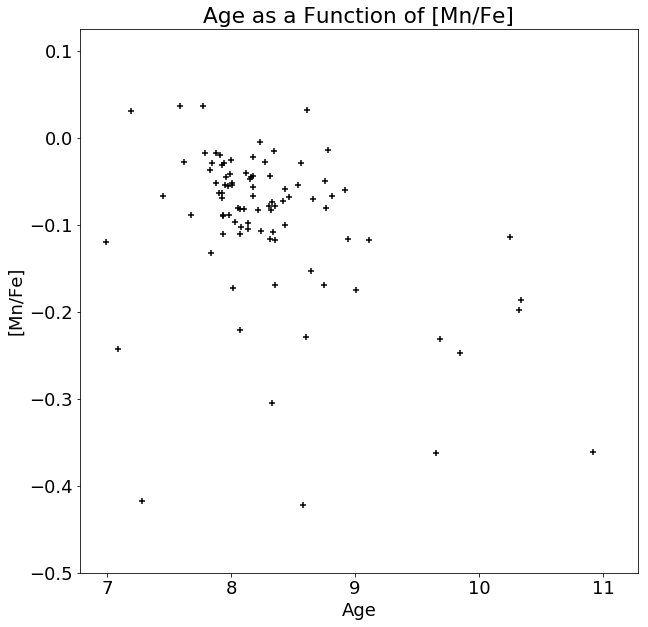

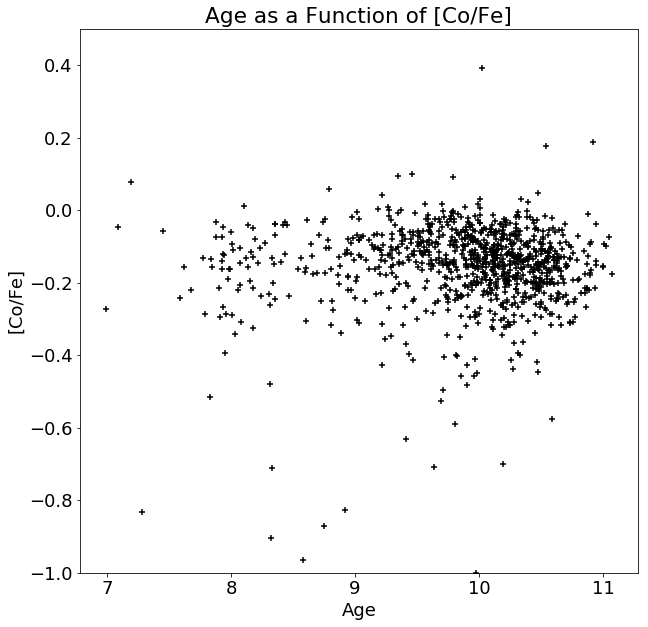

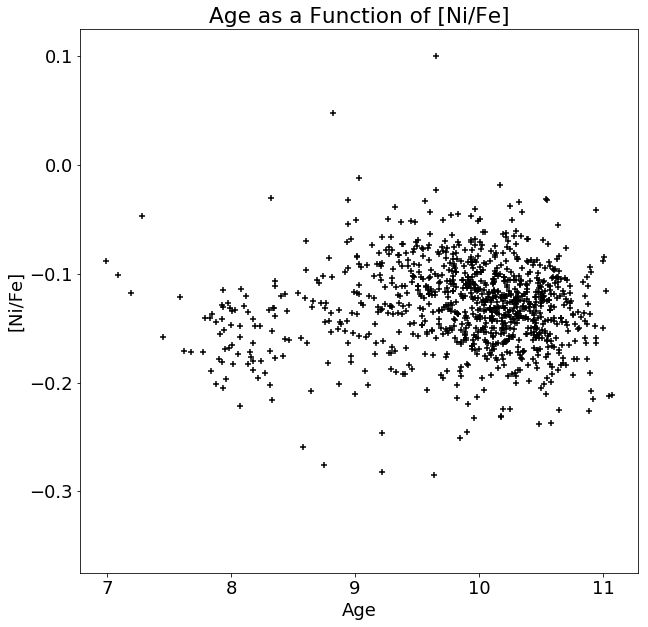

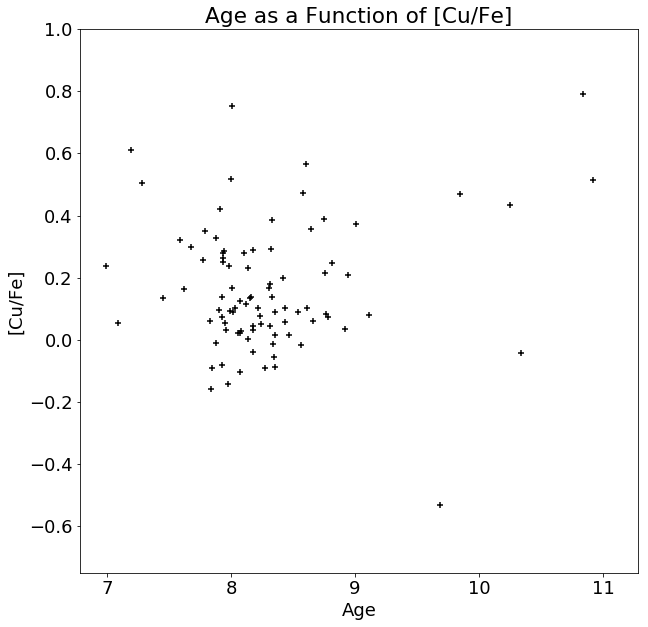

In [39]:
#########################
### Age and Abundance ###
#########################

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['C_FE'],marker='+',c='k')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.2)
plt.title(r'Age as a Function of [C/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['N_FE'],marker='+',c='k')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Age as a Function of [N/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['O_FE'],marker='+',c='k')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.375)
plt.title(r'Age as a Function of [O/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['NA_FE'],marker='+',c='k')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,1)
plt.title(r'Age as a Function of [Na/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['MG_FE'],marker='+',c='k')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.2,0.5)
plt.title(r'Age as a Function of [Mg/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['AL_FE'],marker='+',c='k')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.125)
plt.title(r'Age as a Function of [Al/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['SI_FE'],marker='+',c='k')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.25)
plt.title(r'Age as a Function of [Si/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['K_FE'],marker='+',c='k')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Age as a Function of [K/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['CA_FE'],marker='+',c='k')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.375)
plt.title(r'Age as a Function of [Ca/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['CR_FE'],marker='+',c='k')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.75)
plt.title(r'Age as a Function of [Cr/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['MN_FE'],marker='+',c='k')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,0.125)
plt.title(r'Age as a Function of [Mn/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['CO_FE'],marker='+',c='k')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.5)
plt.title(r'Age as a Function of [Co/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['NI_FE'],marker='+',c='k')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.125)
plt.title(r'Age as a Function of [Ni/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parage[young][cut],dr16snr['CU_FE'],marker='+',c='k')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.75,1)
plt.title(r'Age as a Function of [Cu/Fe]')
plt.show()

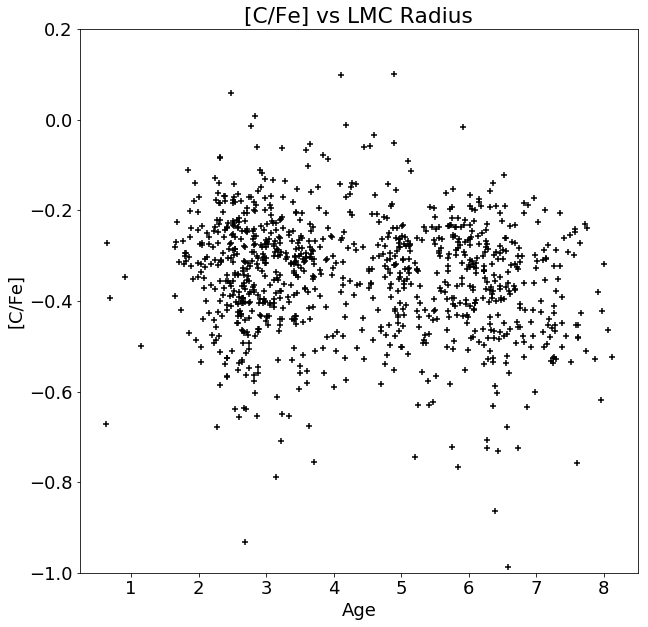

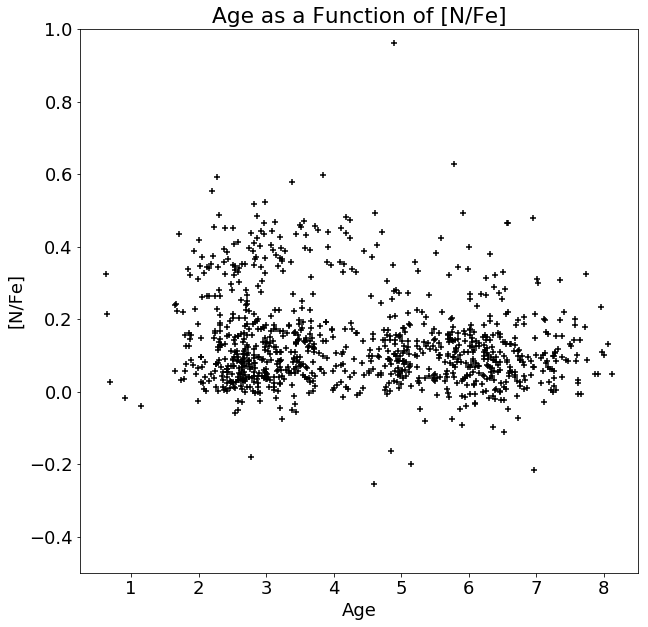

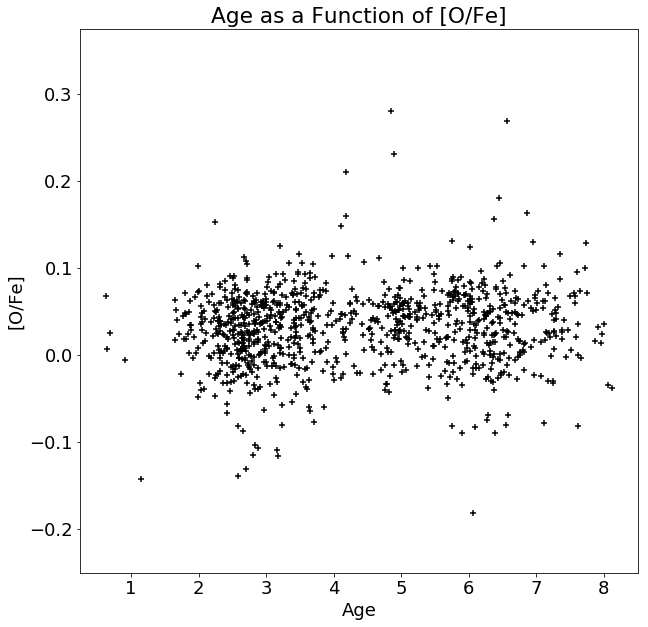

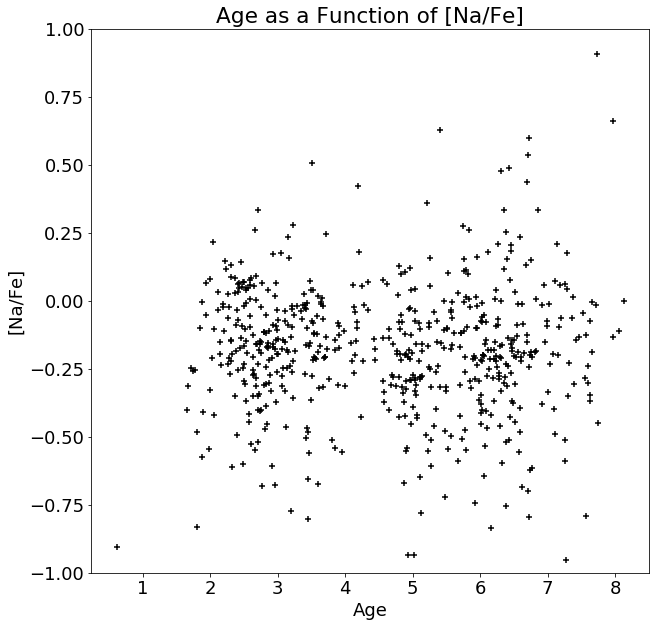

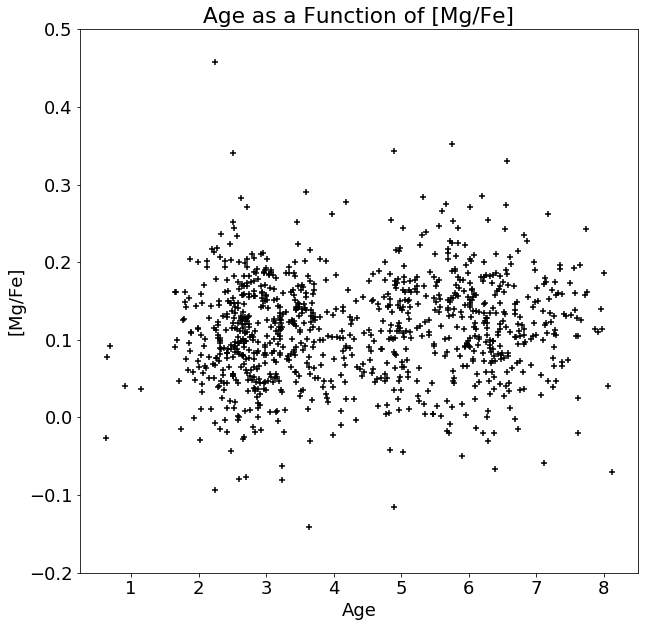

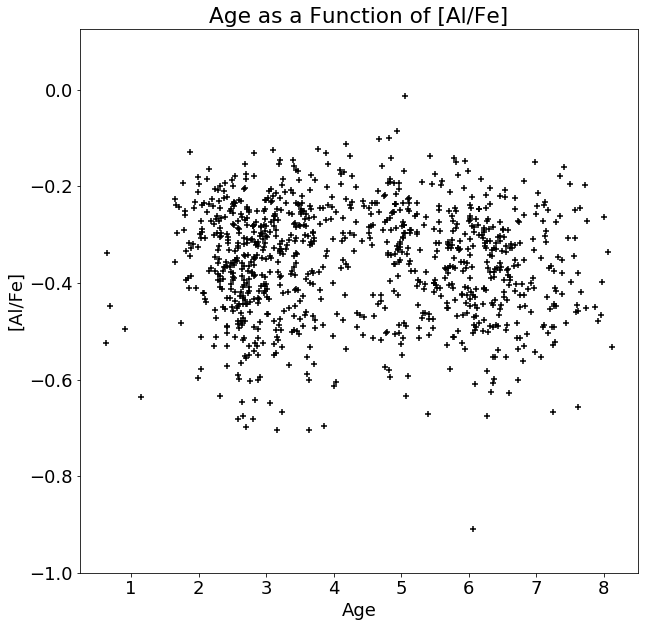

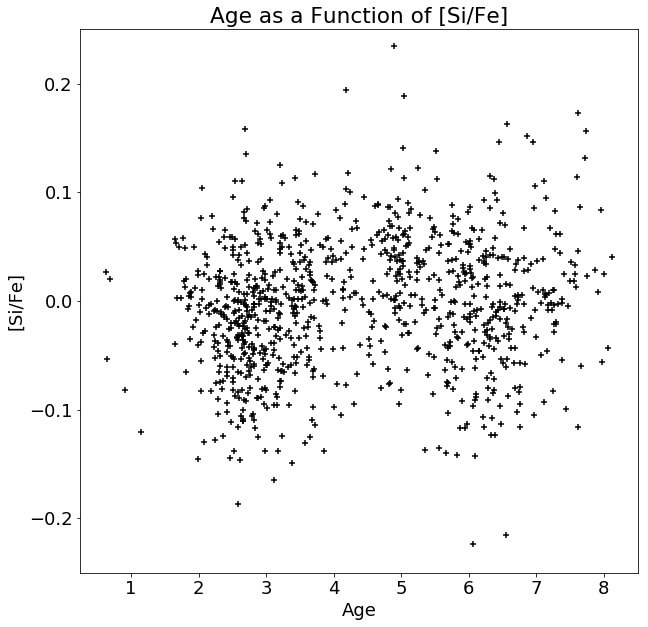

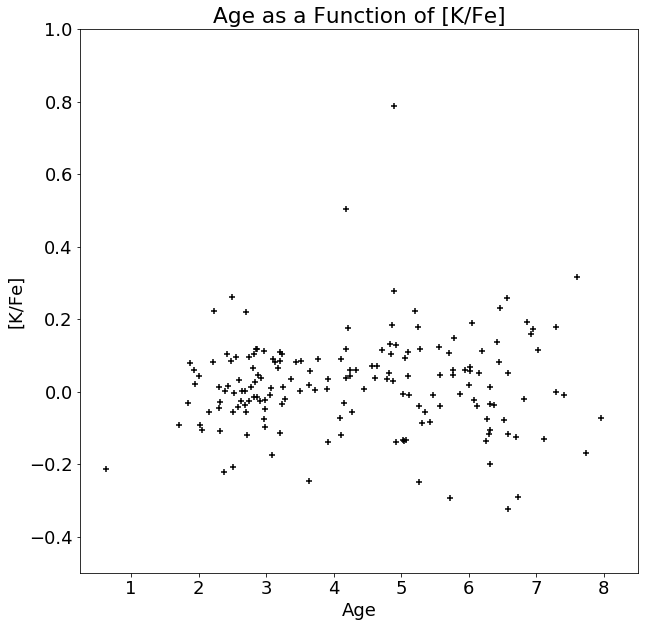

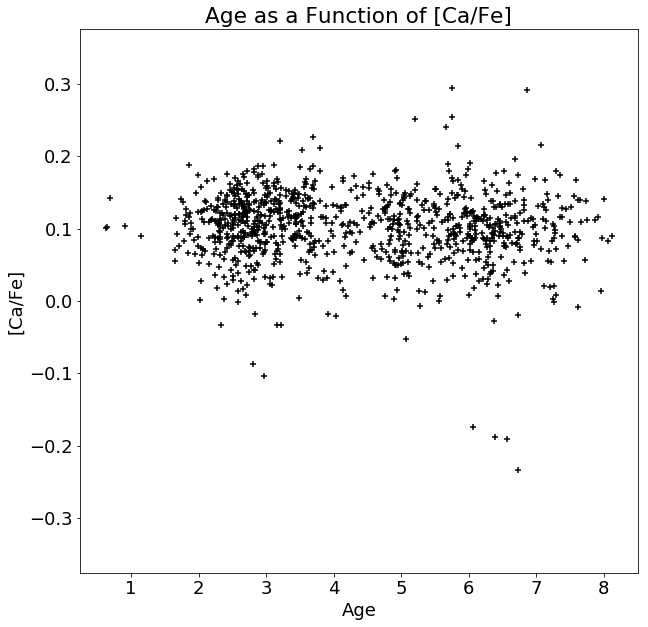

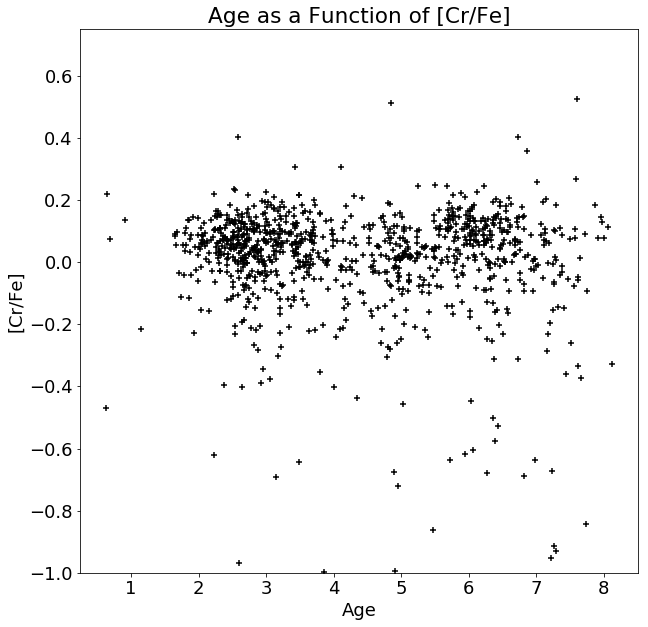

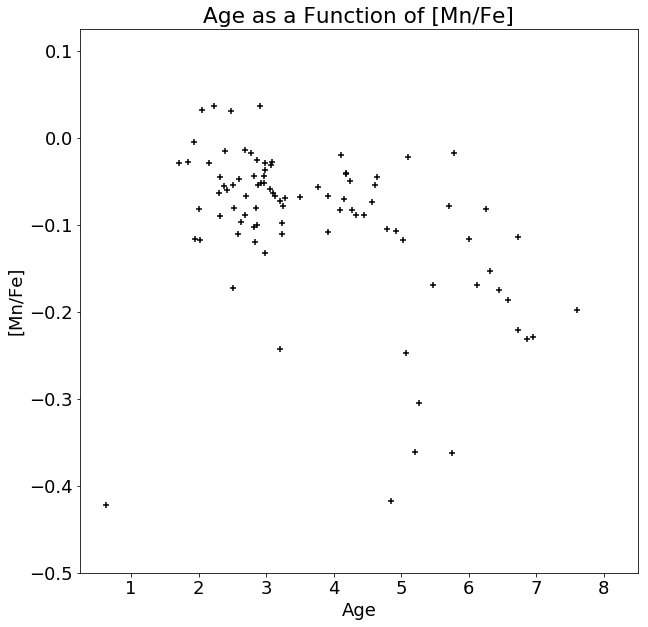

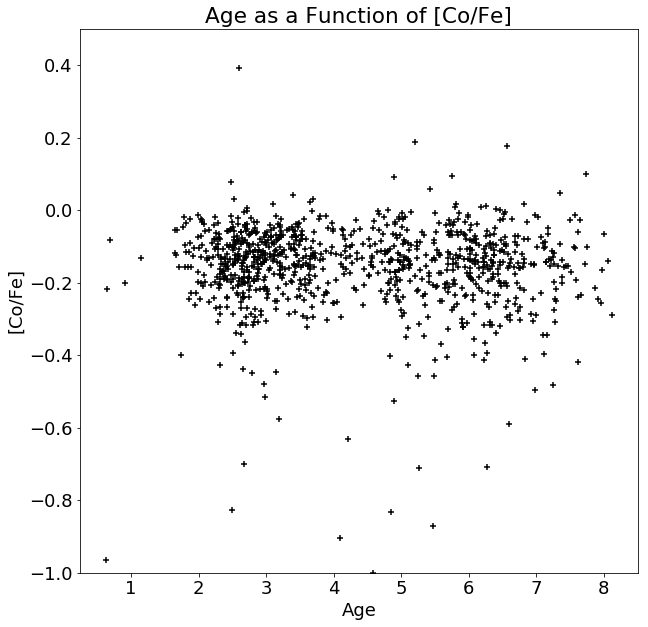

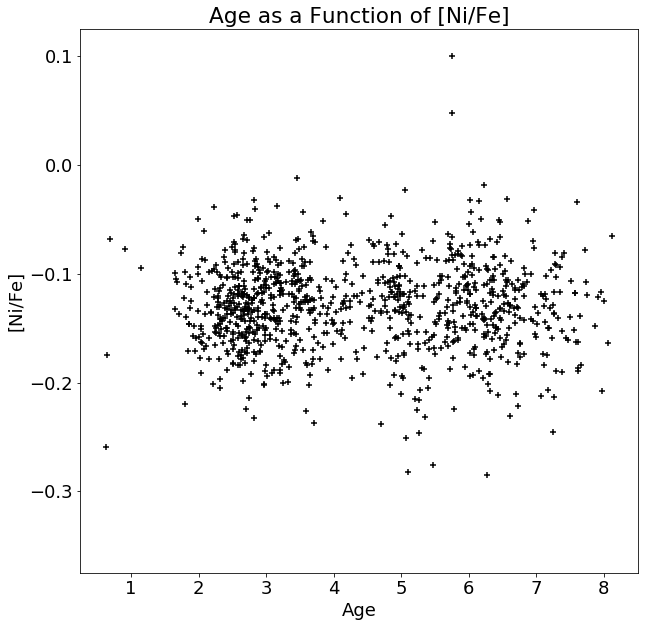

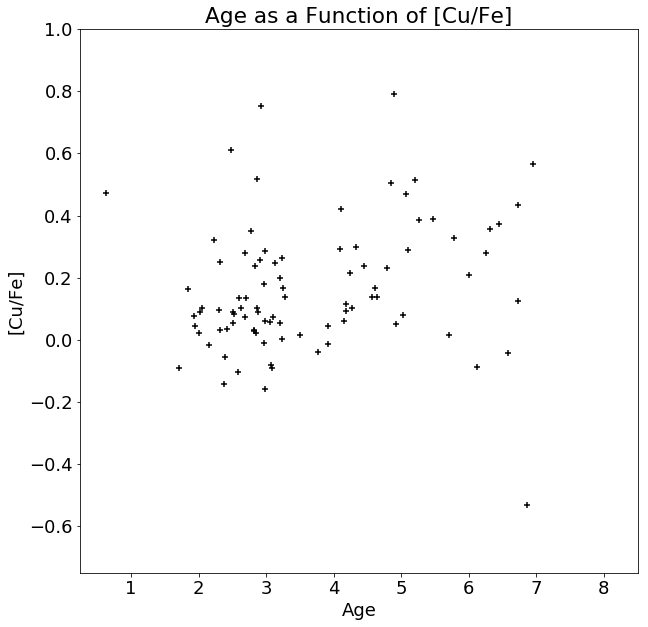

In [40]:
############################
### Abundance and Radius ###
############################

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['C_FE'],marker='+',c='k')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.2)
plt.title(r'[C/Fe] vs LMC Radius')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['N_FE'],marker='+',c='k')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Age as a Function of [N/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['O_FE'],marker='+',c='k')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.375)
plt.title(r'Age as a Function of [O/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['NA_FE'],marker='+',c='k')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,1)
plt.title(r'Age as a Function of [Na/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['MG_FE'],marker='+',c='k')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.2,0.5)
plt.title(r'Age as a Function of [Mg/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['AL_FE'],marker='+',c='k')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.125)
plt.title(r'Age as a Function of [Al/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['SI_FE'],marker='+',c='k')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.25,0.25)
plt.title(r'Age as a Function of [Si/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['K_FE'],marker='+',c='k')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,1)
plt.title(r'Age as a Function of [K/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['CA_FE'],marker='+',c='k')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.375)
plt.title(r'Age as a Function of [Ca/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['CR_FE'],marker='+',c='k')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.75)
plt.title(r'Age as a Function of [Cr/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['MN_FE'],marker='+',c='k')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.5,0.125)
plt.title(r'Age as a Function of [Mn/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['CO_FE'],marker='+',c='k')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'Age')
plt.ylim(-1,0.5)
plt.title(r'Age as a Function of [Co/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['NI_FE'],marker='+',c='k')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.375,0.125)
plt.title(r'Age as a Function of [Ni/Fe]')
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(dr16snr['LMCRAD'],dr16snr['CU_FE'],marker='+',c='k')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'Age')
plt.ylim(-0.75,1)
plt.title(r'Age as a Function of [Cu/Fe]')
plt.show()

In [ ]:
put on git hub


pull out 2 or three elements